In [1]:
import gc
import os

import random
import scipy as sp
import pandas as pd 
import numpy as np 
import seaborn as sns
from pathlib import Path
import joblib
import pickle
import itertools
import matplotlib.pyplot as plt 
from IPython.display import HTML

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
sample_submission = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv')
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [4]:
!mkdir oof
!mkdir models

In [5]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


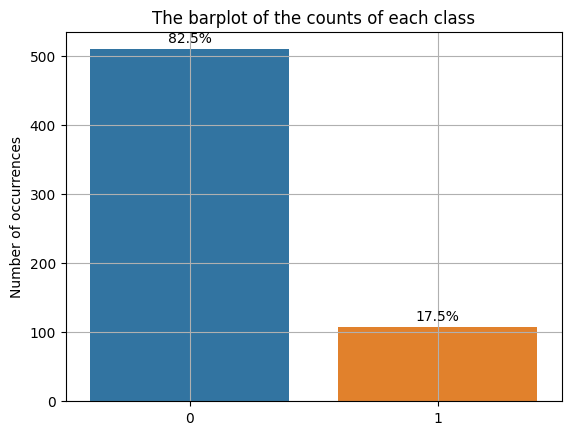

In [6]:
#Check Distribution of two class
class_counts = train.Class.value_counts()
class_percentages = class_counts / class_counts.sum() * 100

# Create the barplot
ax = sns.barplot(x=class_counts.index, y=class_counts)

# Add percentage labels to the bars
for i, v in enumerate(class_counts):
    ax.text(i, v + 5, f"{class_percentages[i]:.1f}%", ha='center', va='bottom')


plt.title('The barplot of the counts of each class')
plt.ylabel('Number of occurrences')
plt.grid()
plt.show()

In [7]:
#About 17.5% of people in the training set have one of the 3 diseases
#It's an imbalanced dataset, but not extermely imbalaced, so I didn't apply over-sampling method.

In [8]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['kurtosis'] = df.kurtosis()
    summ['first value'] = df.loc[0].values
    summ['last value'] = df.iloc[-1].values
    
    return summ
analysis_table=summary(train)

data shape: (617, 58)


In [9]:
# Define a function to highlight rows based on certain conditions
def highlight_rows(row):
    color = 'background-color: red'
    criteria1 = row['%missing'] > 50
    criteria2 = abs(row['kurtosis']) > 100
    #criteria3 = row['#unique']>=615
    
    if criteria1 or criteria2:
        return [color] * len(row)
    else:
        return [''] * len(row)

# Apply the row highlighting function to the analysis table
analysis_table = analysis_table.style.apply(highlight_rows, axis=1)

# Display the analysis table
HTML(analysis_table.render())

,data type,#missing,%missing,#unique,min,max,kurtosis,first value,last value
Id,object,0,0.000000,617,nan,nan,nan,000ff2bfdfe9,ffcca4ded3bb
AB,float64,0,0.000000,217,0.081187,6.161666,53.027994,0.209377,0.482849
AF,float64,0,0.000000,599,192.593280,28688.187660,30.046579,3109.033290,2672.534260
AH,float64,0,0.000000,227,85.200147,1910.123198,123.880298,85.200147,546.663930
AM,float64,0,0.000000,605,3.177522,630.518230,48.583199,22.394407,112.006102
AR,float64,0,0.000000,130,8.138688,178.943634,202.672415,8.138688,8.138688
AX,float64,0,0.000000,427,0.699861,38.270880,45.729751,0.699861,3.198099
AY,float64,0,0.000000,148,0.025578,10.315851,597.760144,0.025578,0.116928
AZ,float64,0,0.000000,484,3.396778,38.971568,3.506581,9.812214,3.396778
BC,float64,0,0.000000,259,1.229900,1463.693448,420.083106,5.555634,7.948668


In [10]:
#Check Duplicate ID
duplicate_ids = train.duplicated(subset='Id', keep=False)

# Check if any duplicates exist
if duplicate_ids.any():
    # Print the duplicate IDs
    duplicate_id_list = df.loc[duplicate_ids, 'Id'].unique().tolist()
    print("Duplicate IDs:", duplicate_id_list)
else:
    print("No duplicate IDs found.")

No duplicate IDs found.


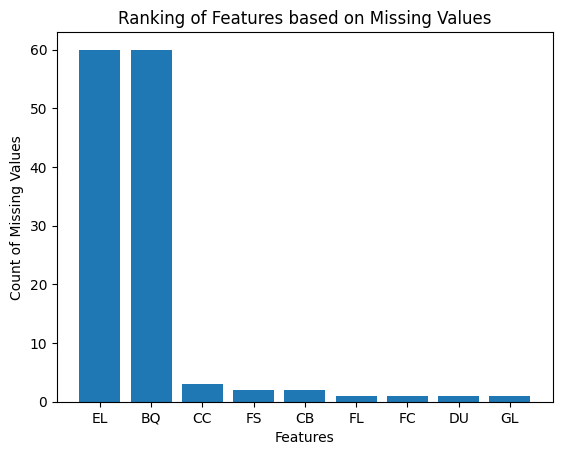

In [11]:
#Check Missing Data
missing_values=train.isnull().sum()
sorted_missing_values=missing_values.sort_values(ascending=False)
filtered_missing_values = sorted_missing_values[sorted_missing_values > 0]

#Visulize the result
plt.bar(filtered_missing_values.index, filtered_missing_values)
plt.xlabel('Features')
plt.ylabel('Count of Missing Values')
plt.title('Ranking of Features based on Missing Values')
plt.show()

There are 9 features that contain missing values in the dataset. Among these features, "EL" and "BQ" have the highest number of missing values, with 60 occurrences each. These 60 missing values account for approximately 9.7% of the total observations. The remaining features have less than 10 missing values each. Therefore, this dataset is reliable and the missing value is not a big problem.

In [12]:
num_cols = test.select_dtypes(include=['float64']).columns.tolist()
cat_cols = test.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Id')

In [13]:
#Check the distribution of conlumn EJ
train[cat_cols].value_counts()

EJ
B     395
A     222
dtype: int64

In [14]:
features = [c for c in train.columns if c!='Id' and c!='Class']
df_features=train[features]
df_features.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,11.516657,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,35.851039,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000


In [15]:
#Divide the numerical features into 5 sets and visulizae their distribution
sets=[]
set_size = 10  
num_sets = 6  
for i in range(num_sets):
    start_index = i * set_size  # Starting index of the set
    end_index = (i + 1) * set_size  # Ending index of the set

    if i == num_sets - 1:
        # For the last set, adjust the end index to accommodate the remaining elements
        end_index += len(num_cols) % set_size

    subset = num_cols[start_index:end_index]  # Subset of numbers for the current set
    sets.append(subset)  # Add the subset to the list of sets

# Print the sets
for i, subset in enumerate(sets):
    print(f"Set {i + 1}: {subset}")

Set 1: ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ']
Set 2: ['BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH']
Set 3: ['CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI']
Set 4: ['DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EL']
Set 5: ['EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB']
Set 6: ['GE', 'GF', 'GH', 'GI', 'GL']


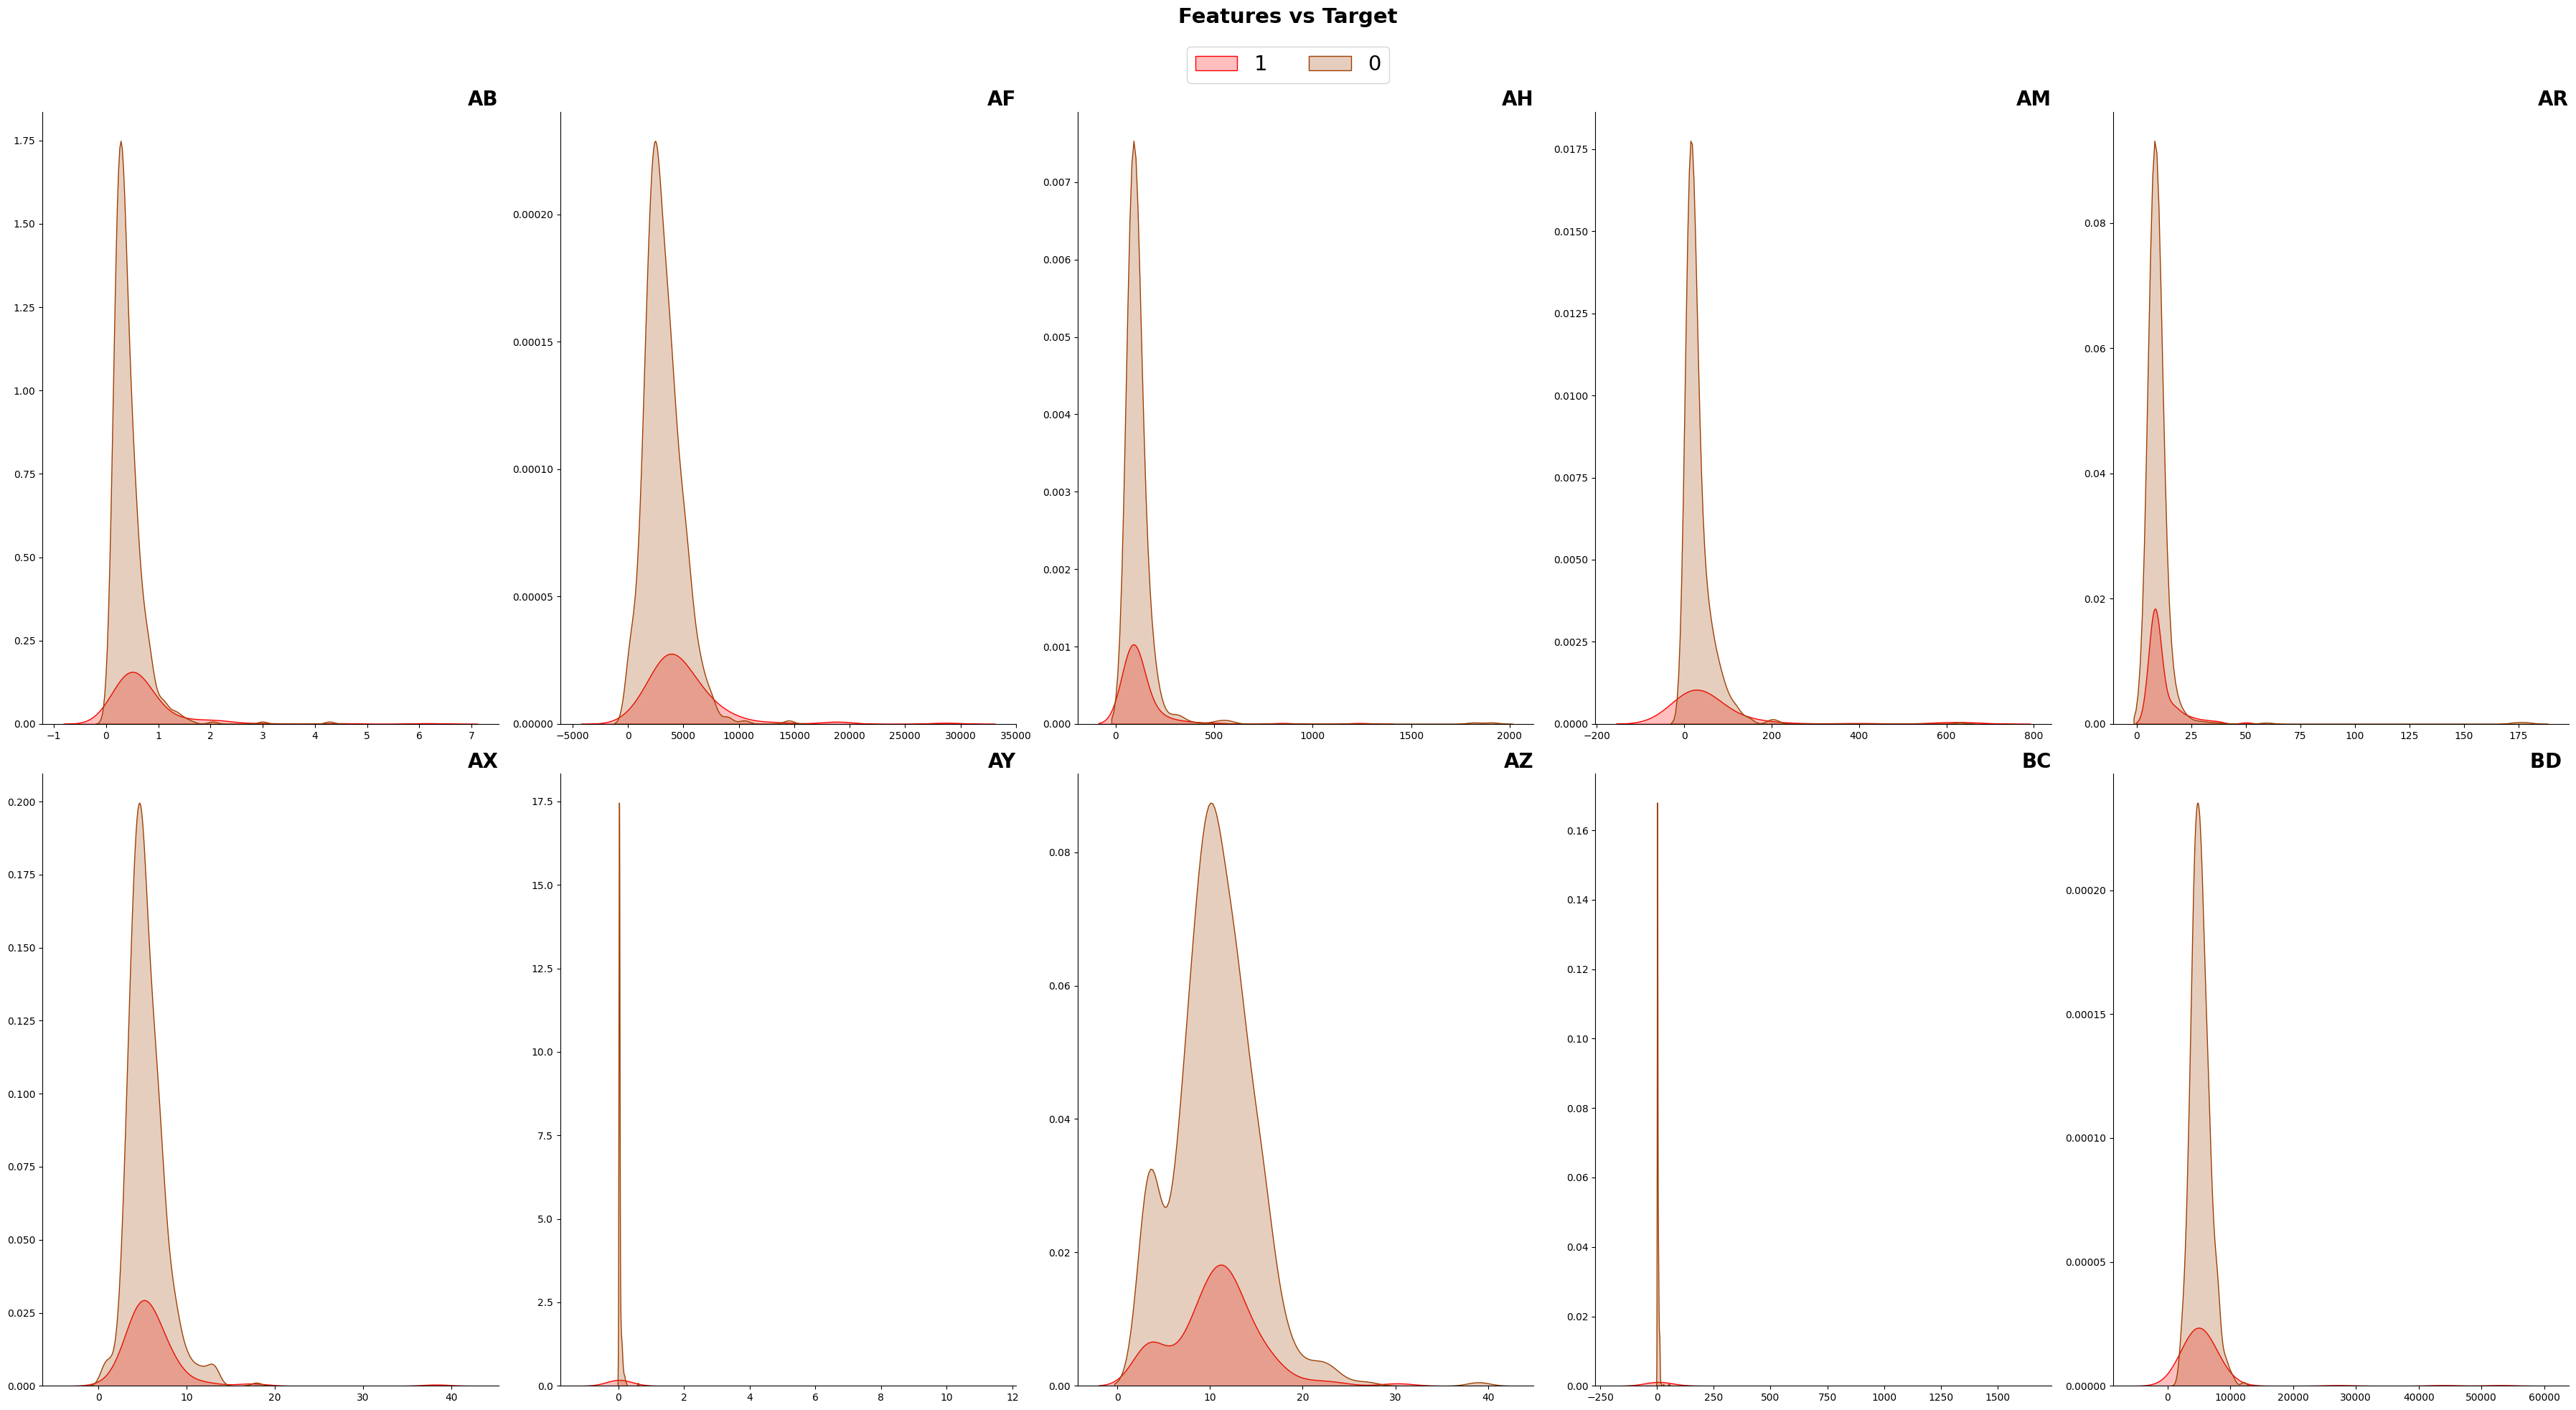

In [16]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(sets[0]):
    ax = plt.subplot(2,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

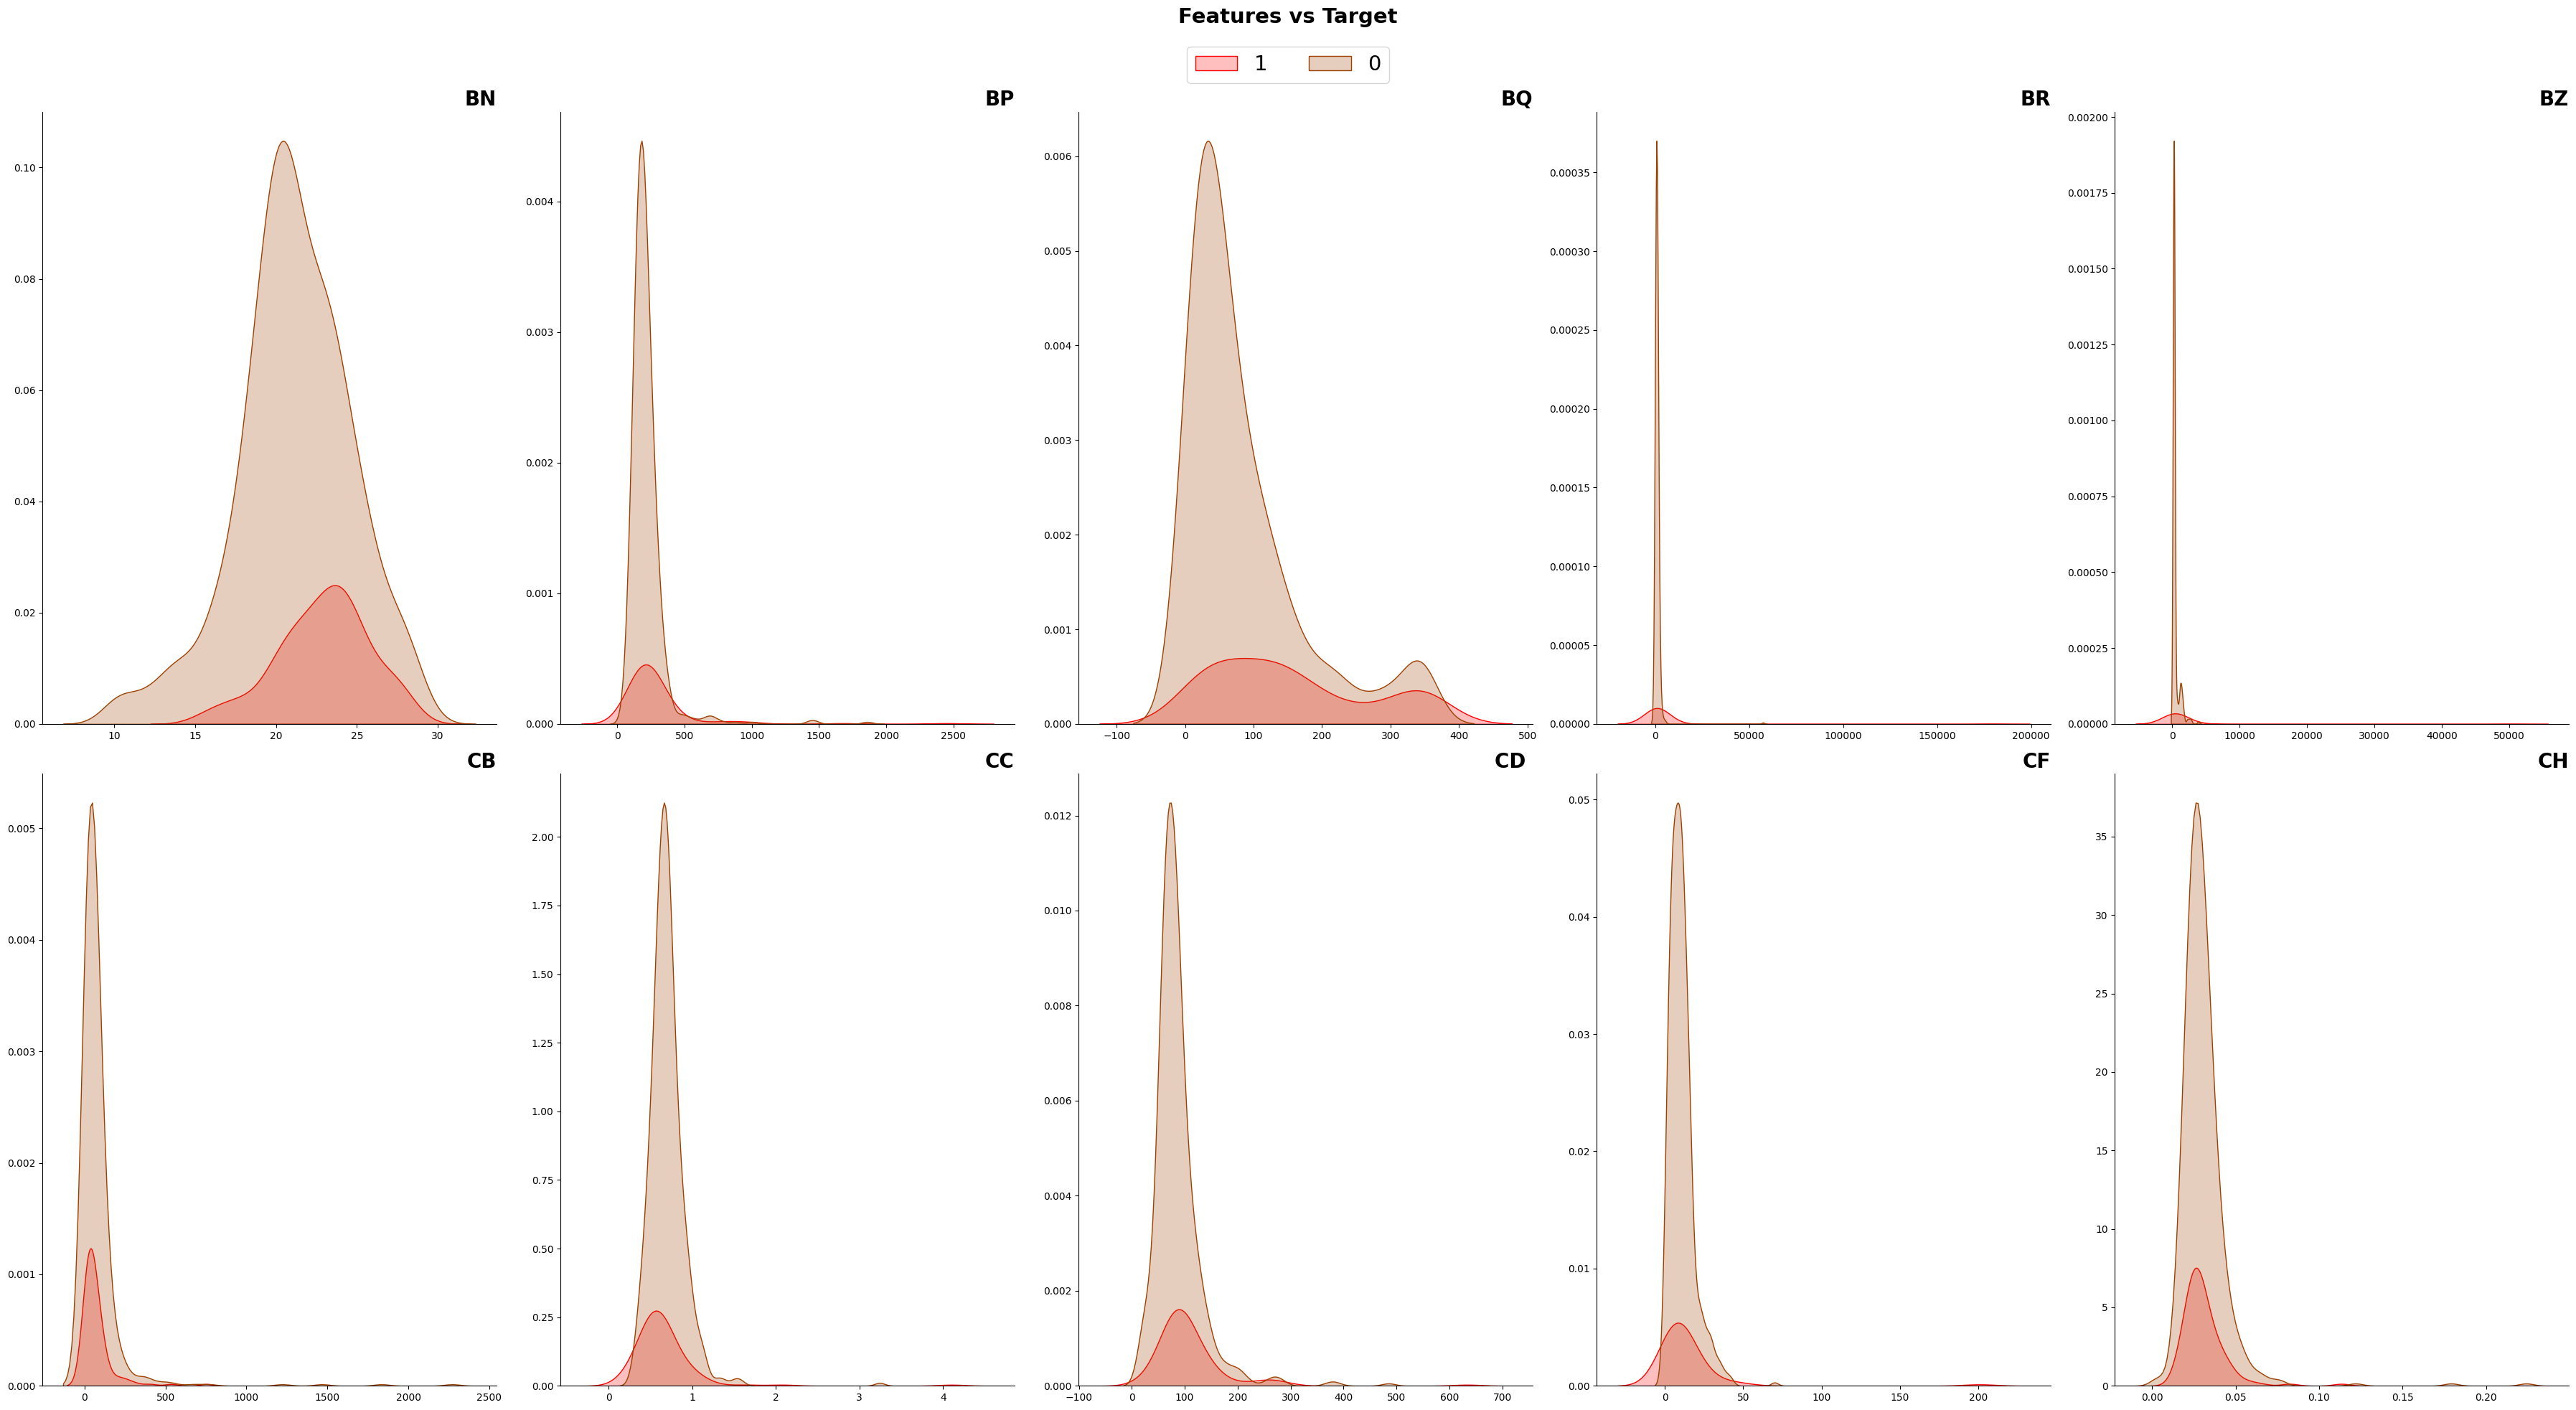

In [17]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(sets[1]):
    ax = plt.subplot(2,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

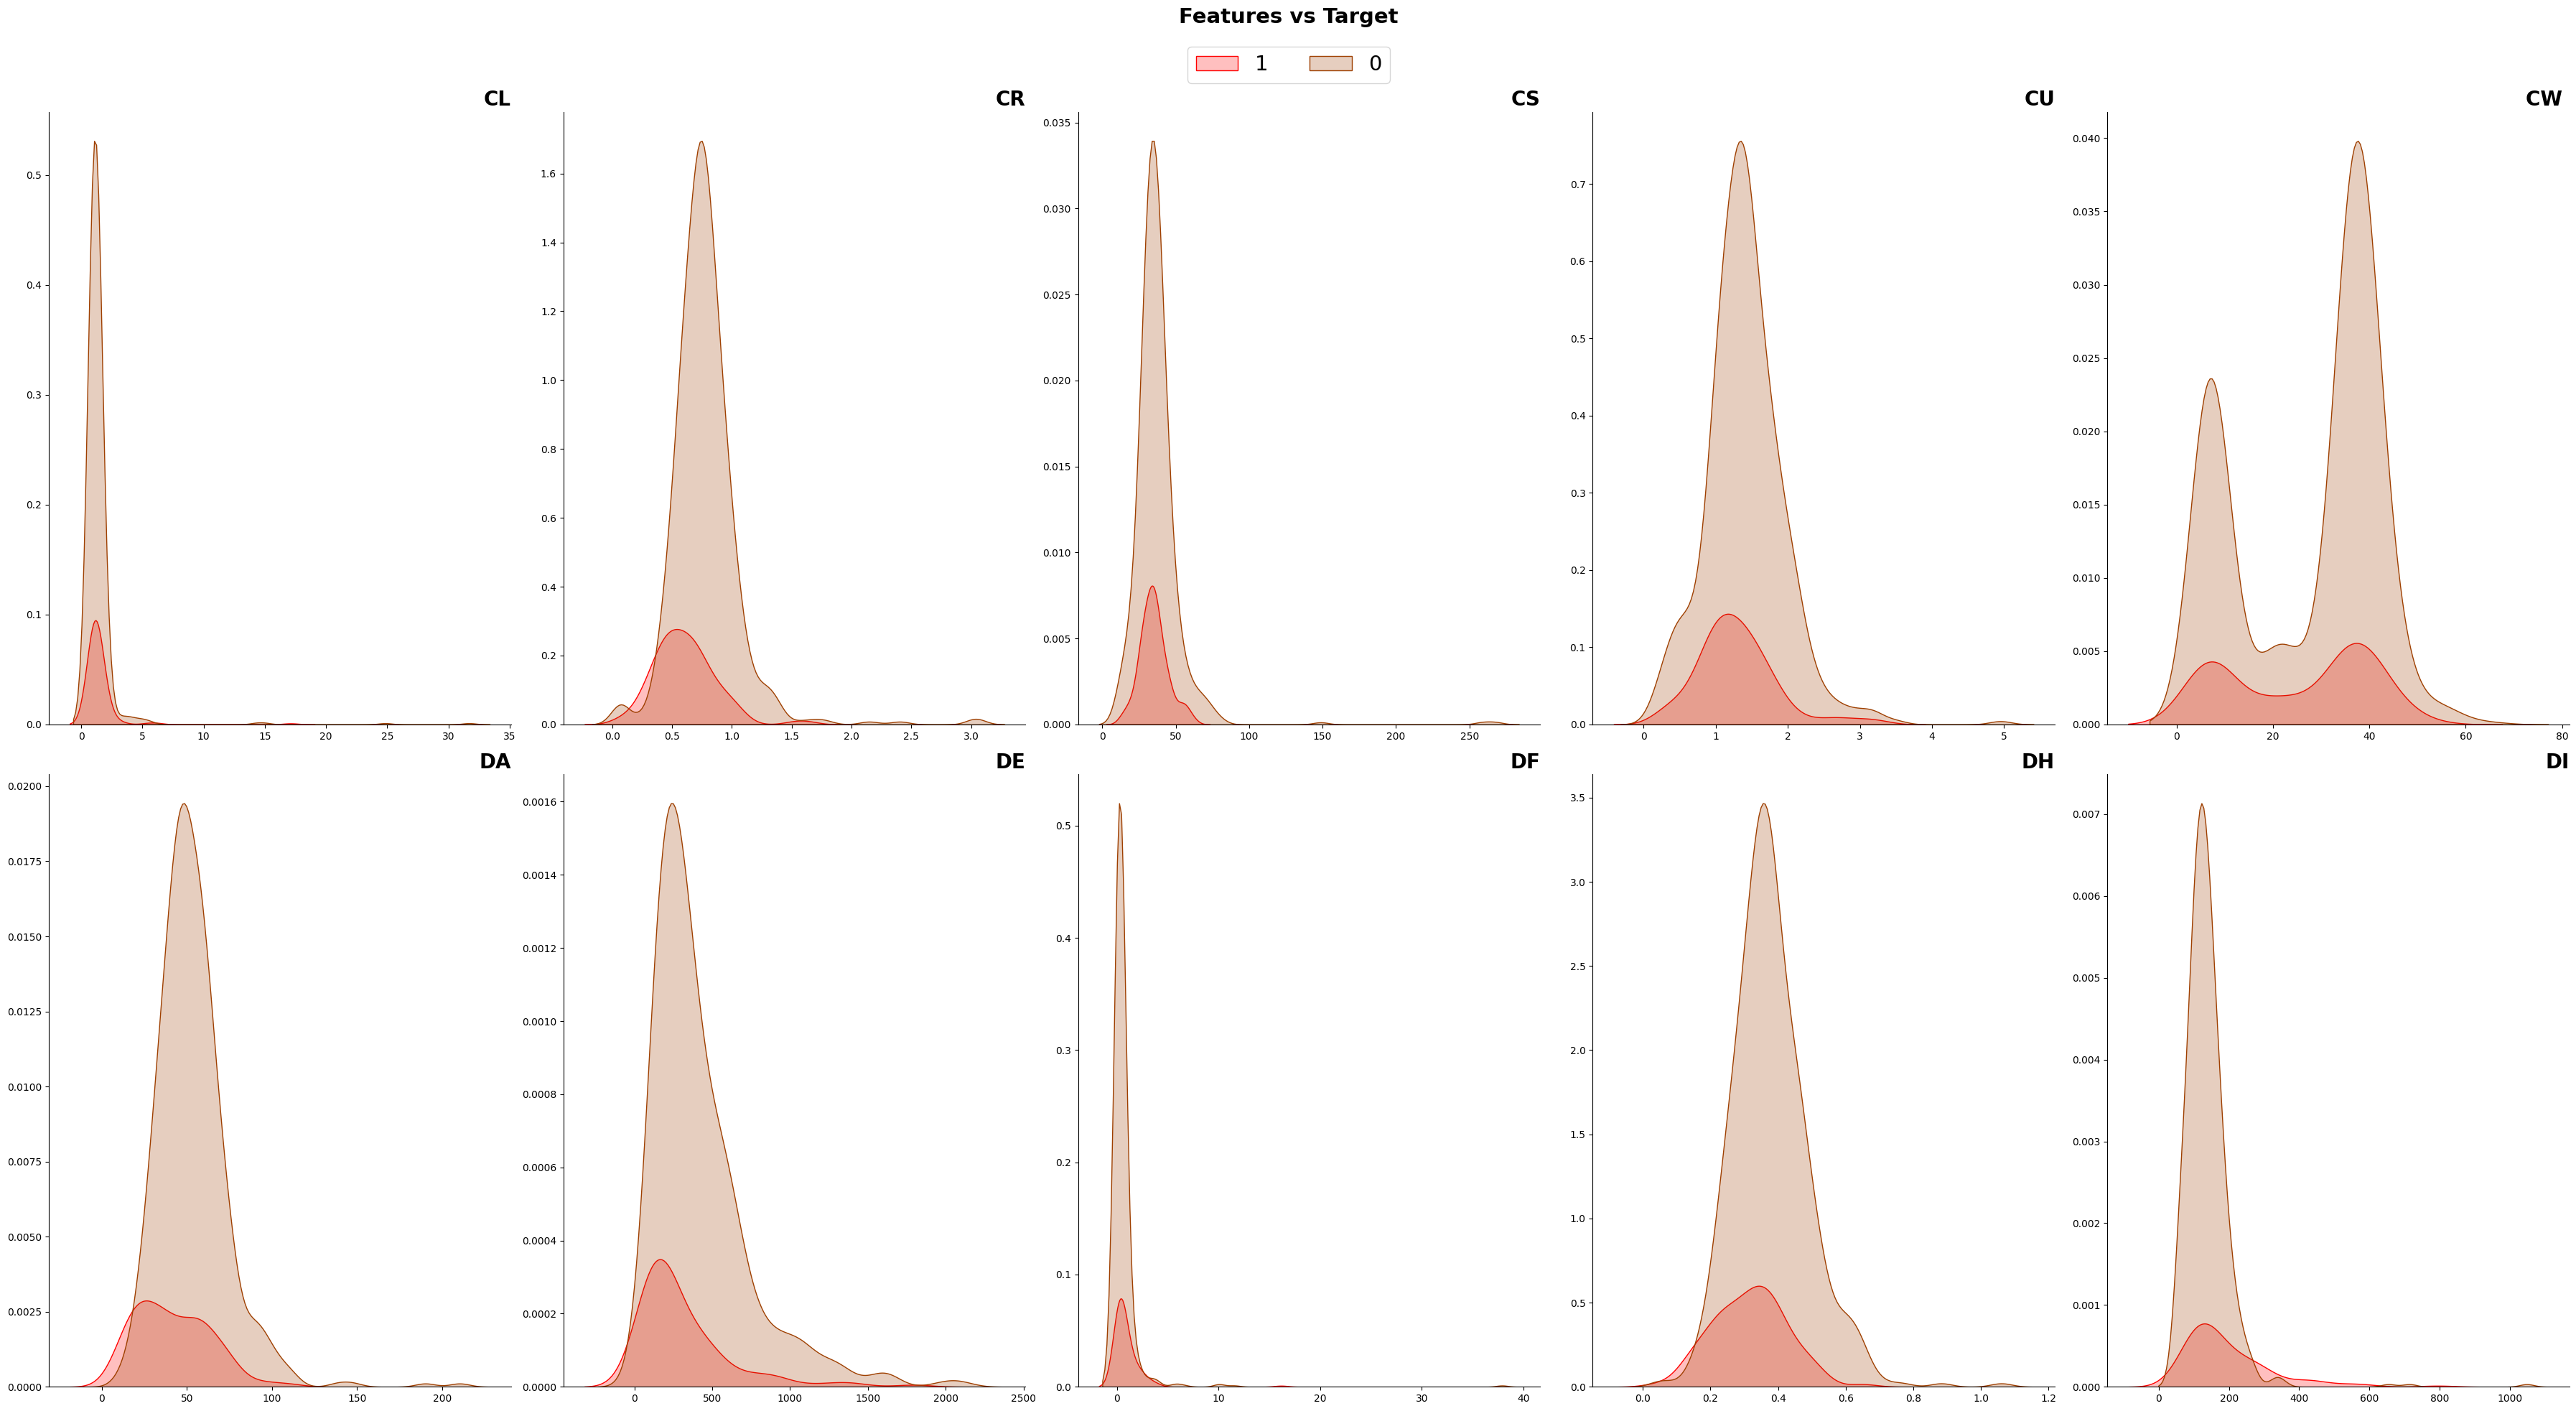

In [18]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(sets[2]):
    ax = plt.subplot(2,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

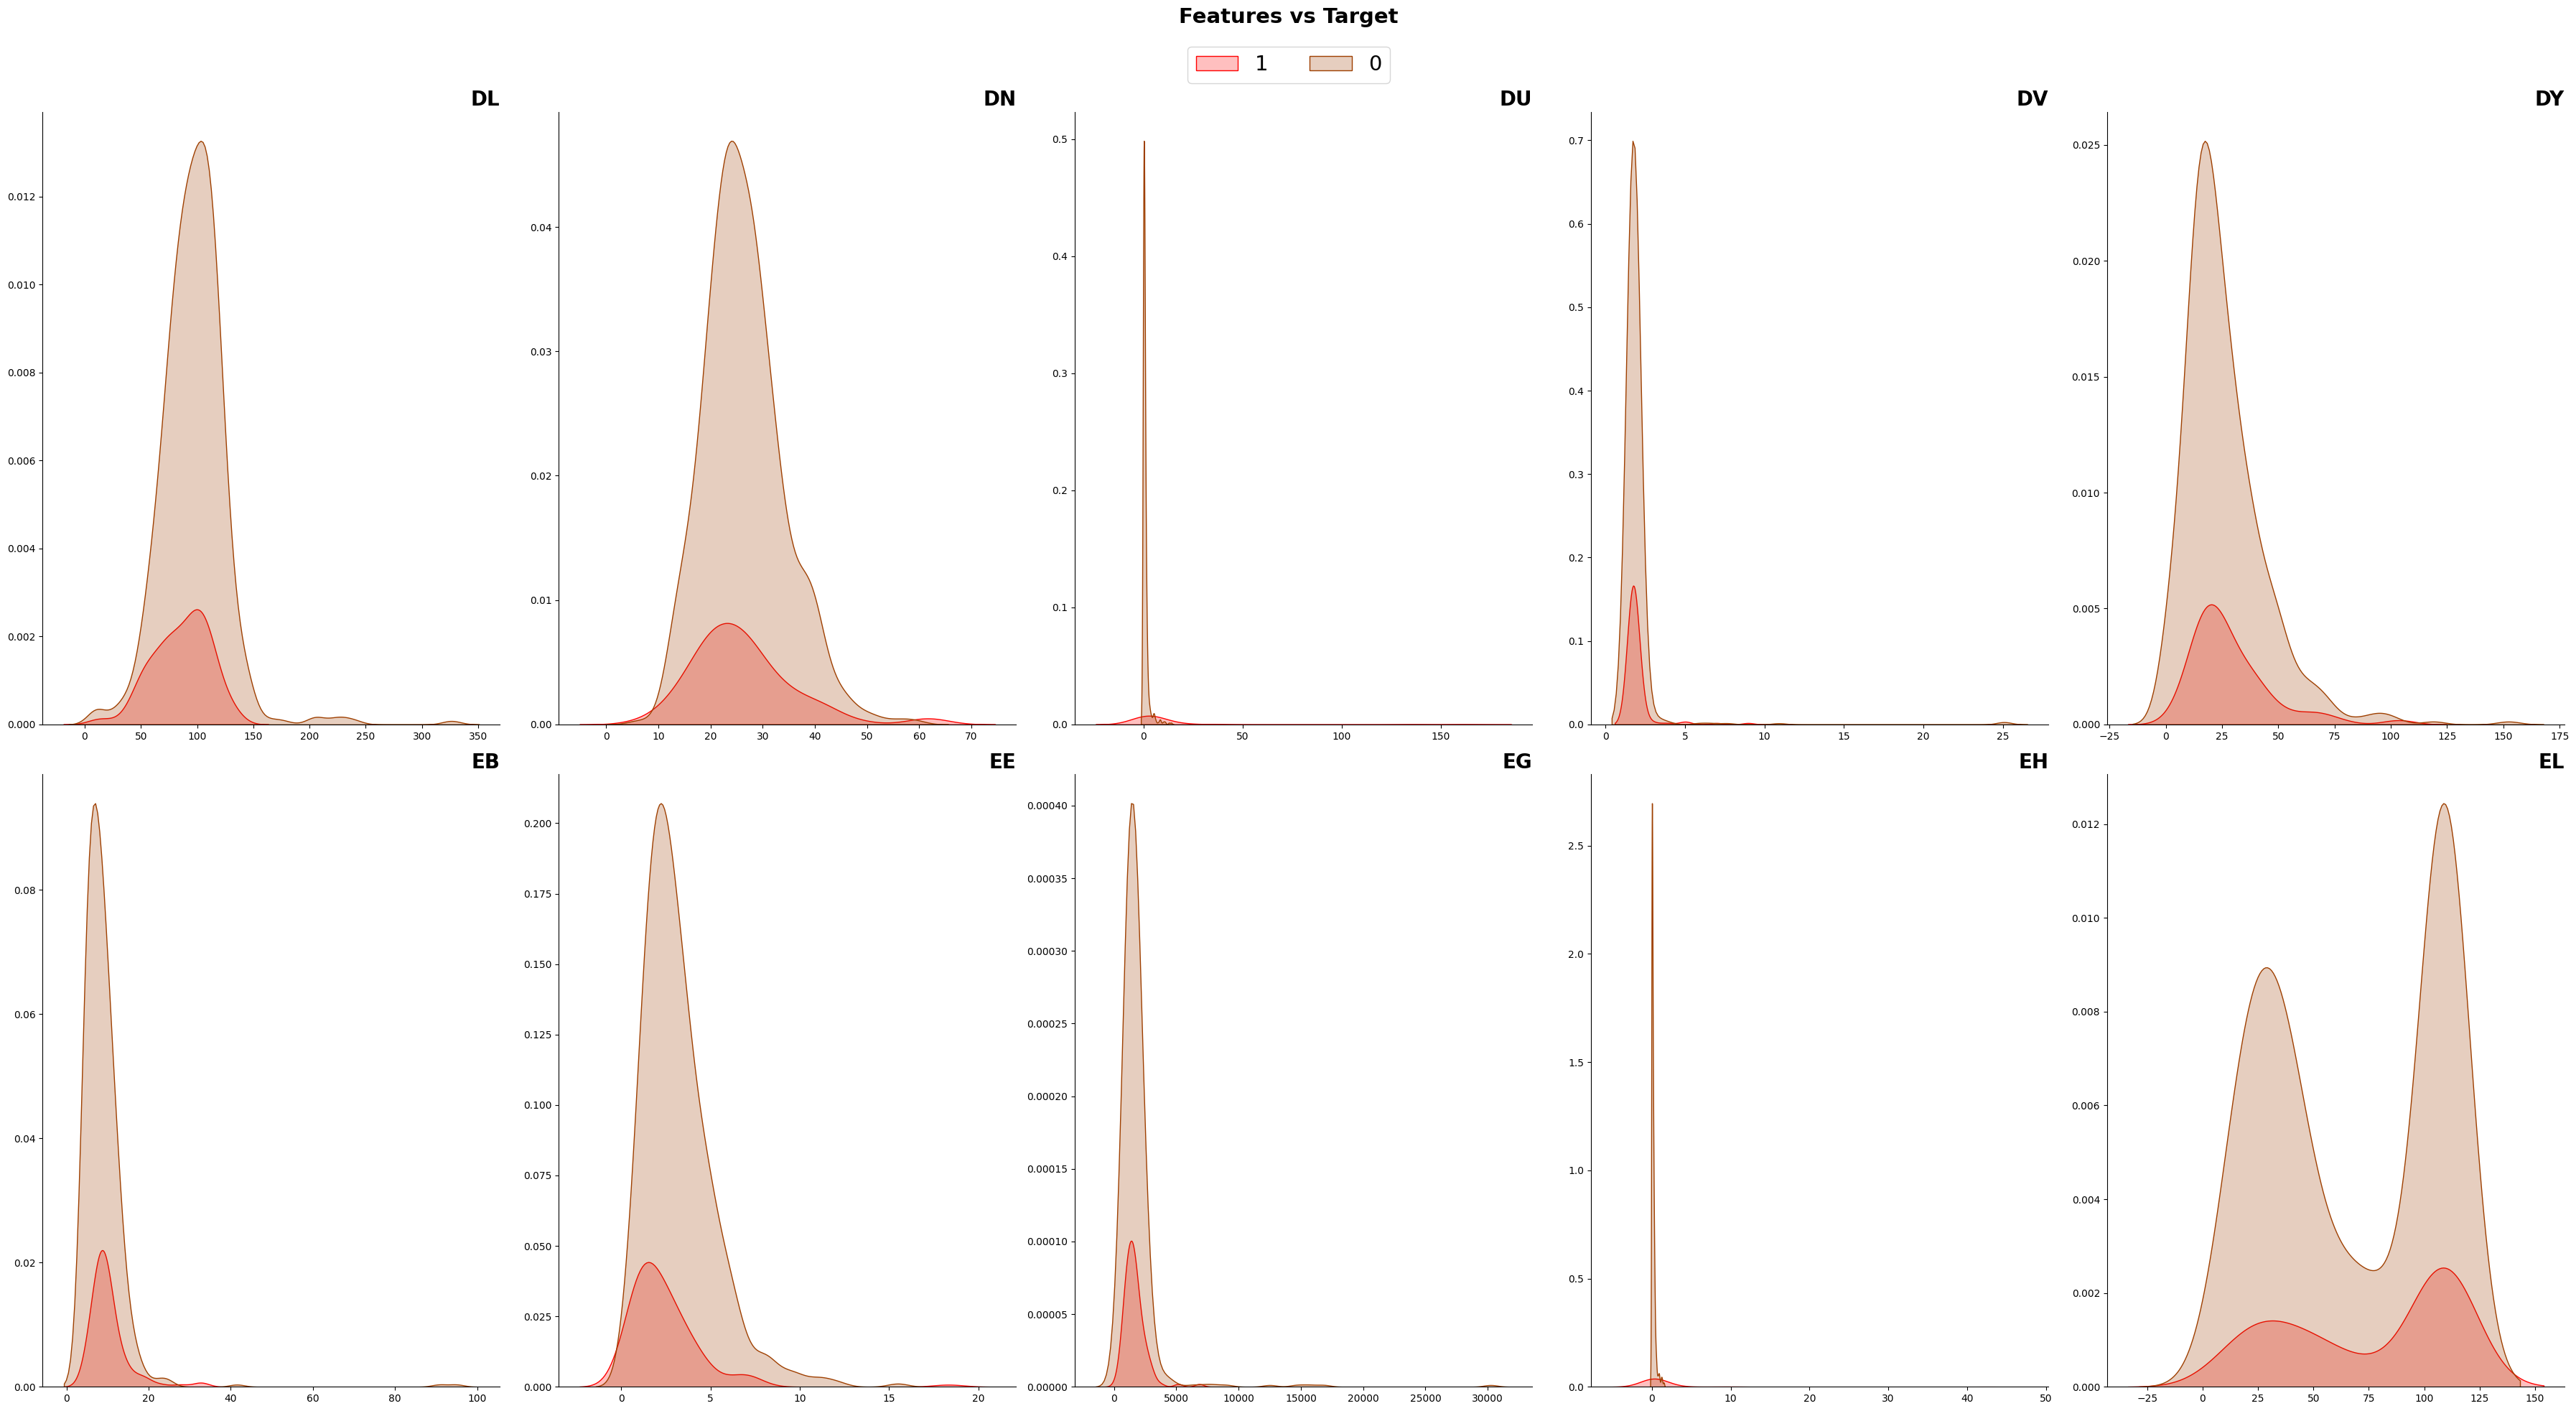

In [19]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(sets[3]):
    ax = plt.subplot(2,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

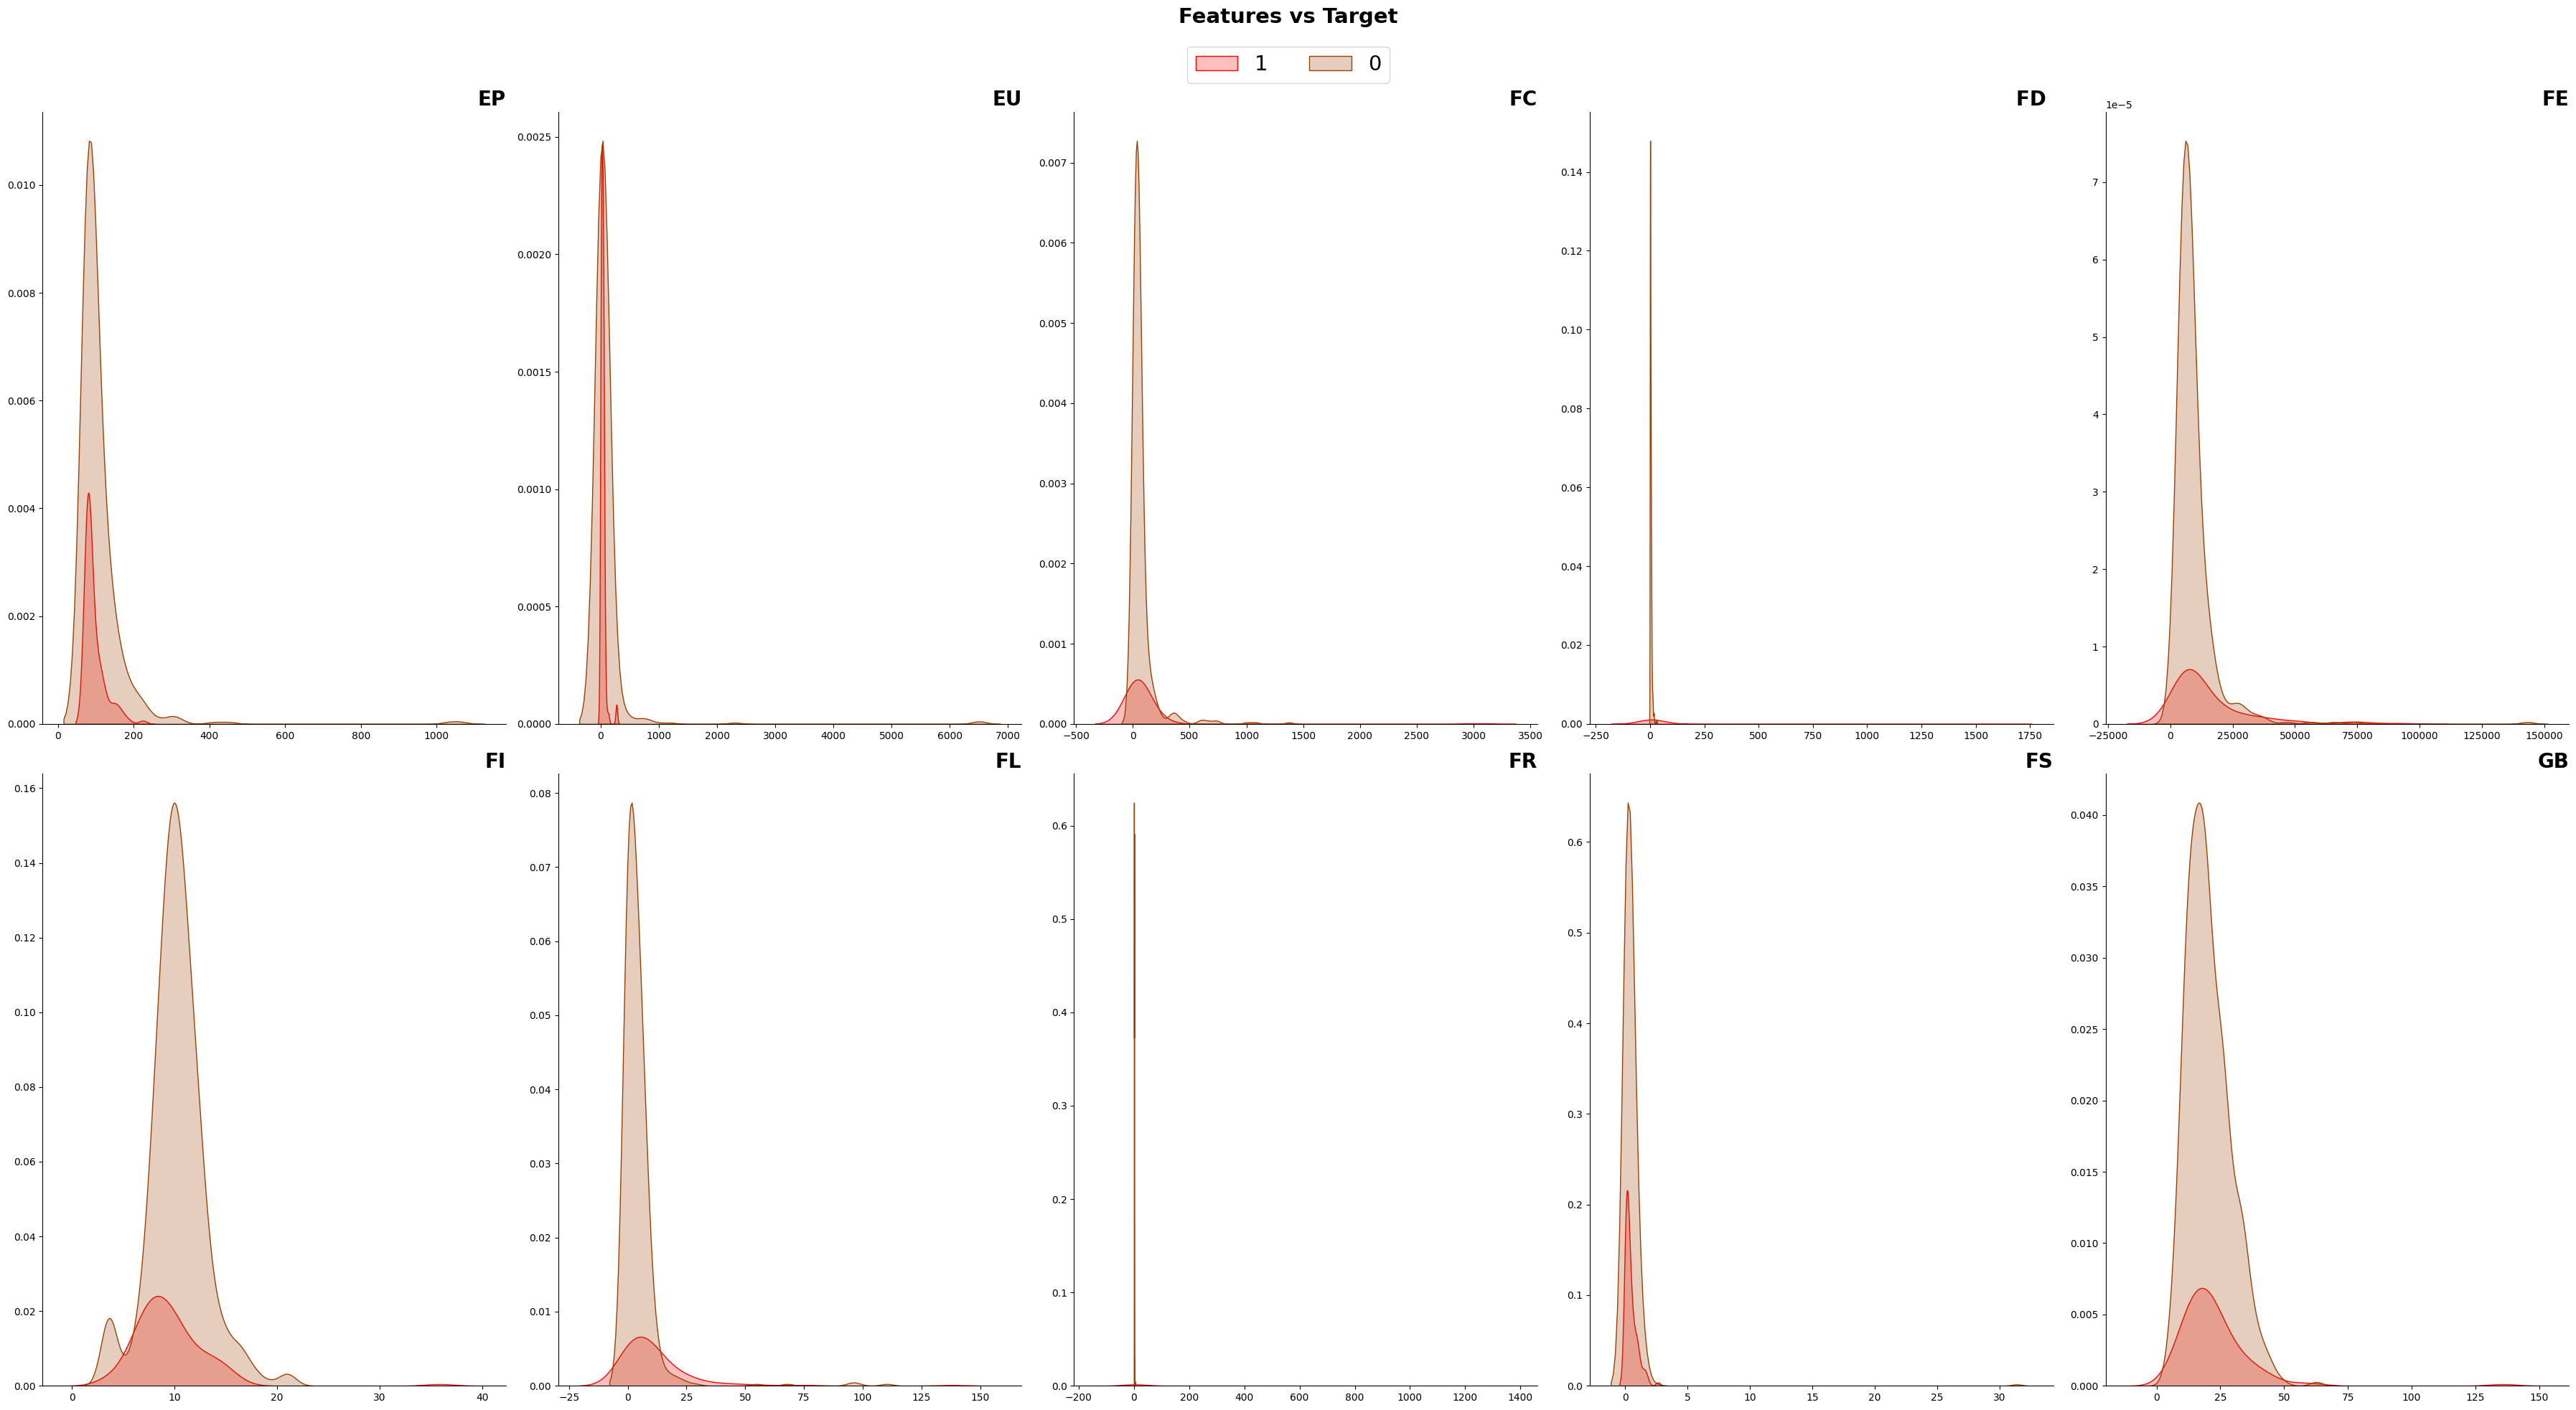

In [20]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(sets[4]):
    ax = plt.subplot(2,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

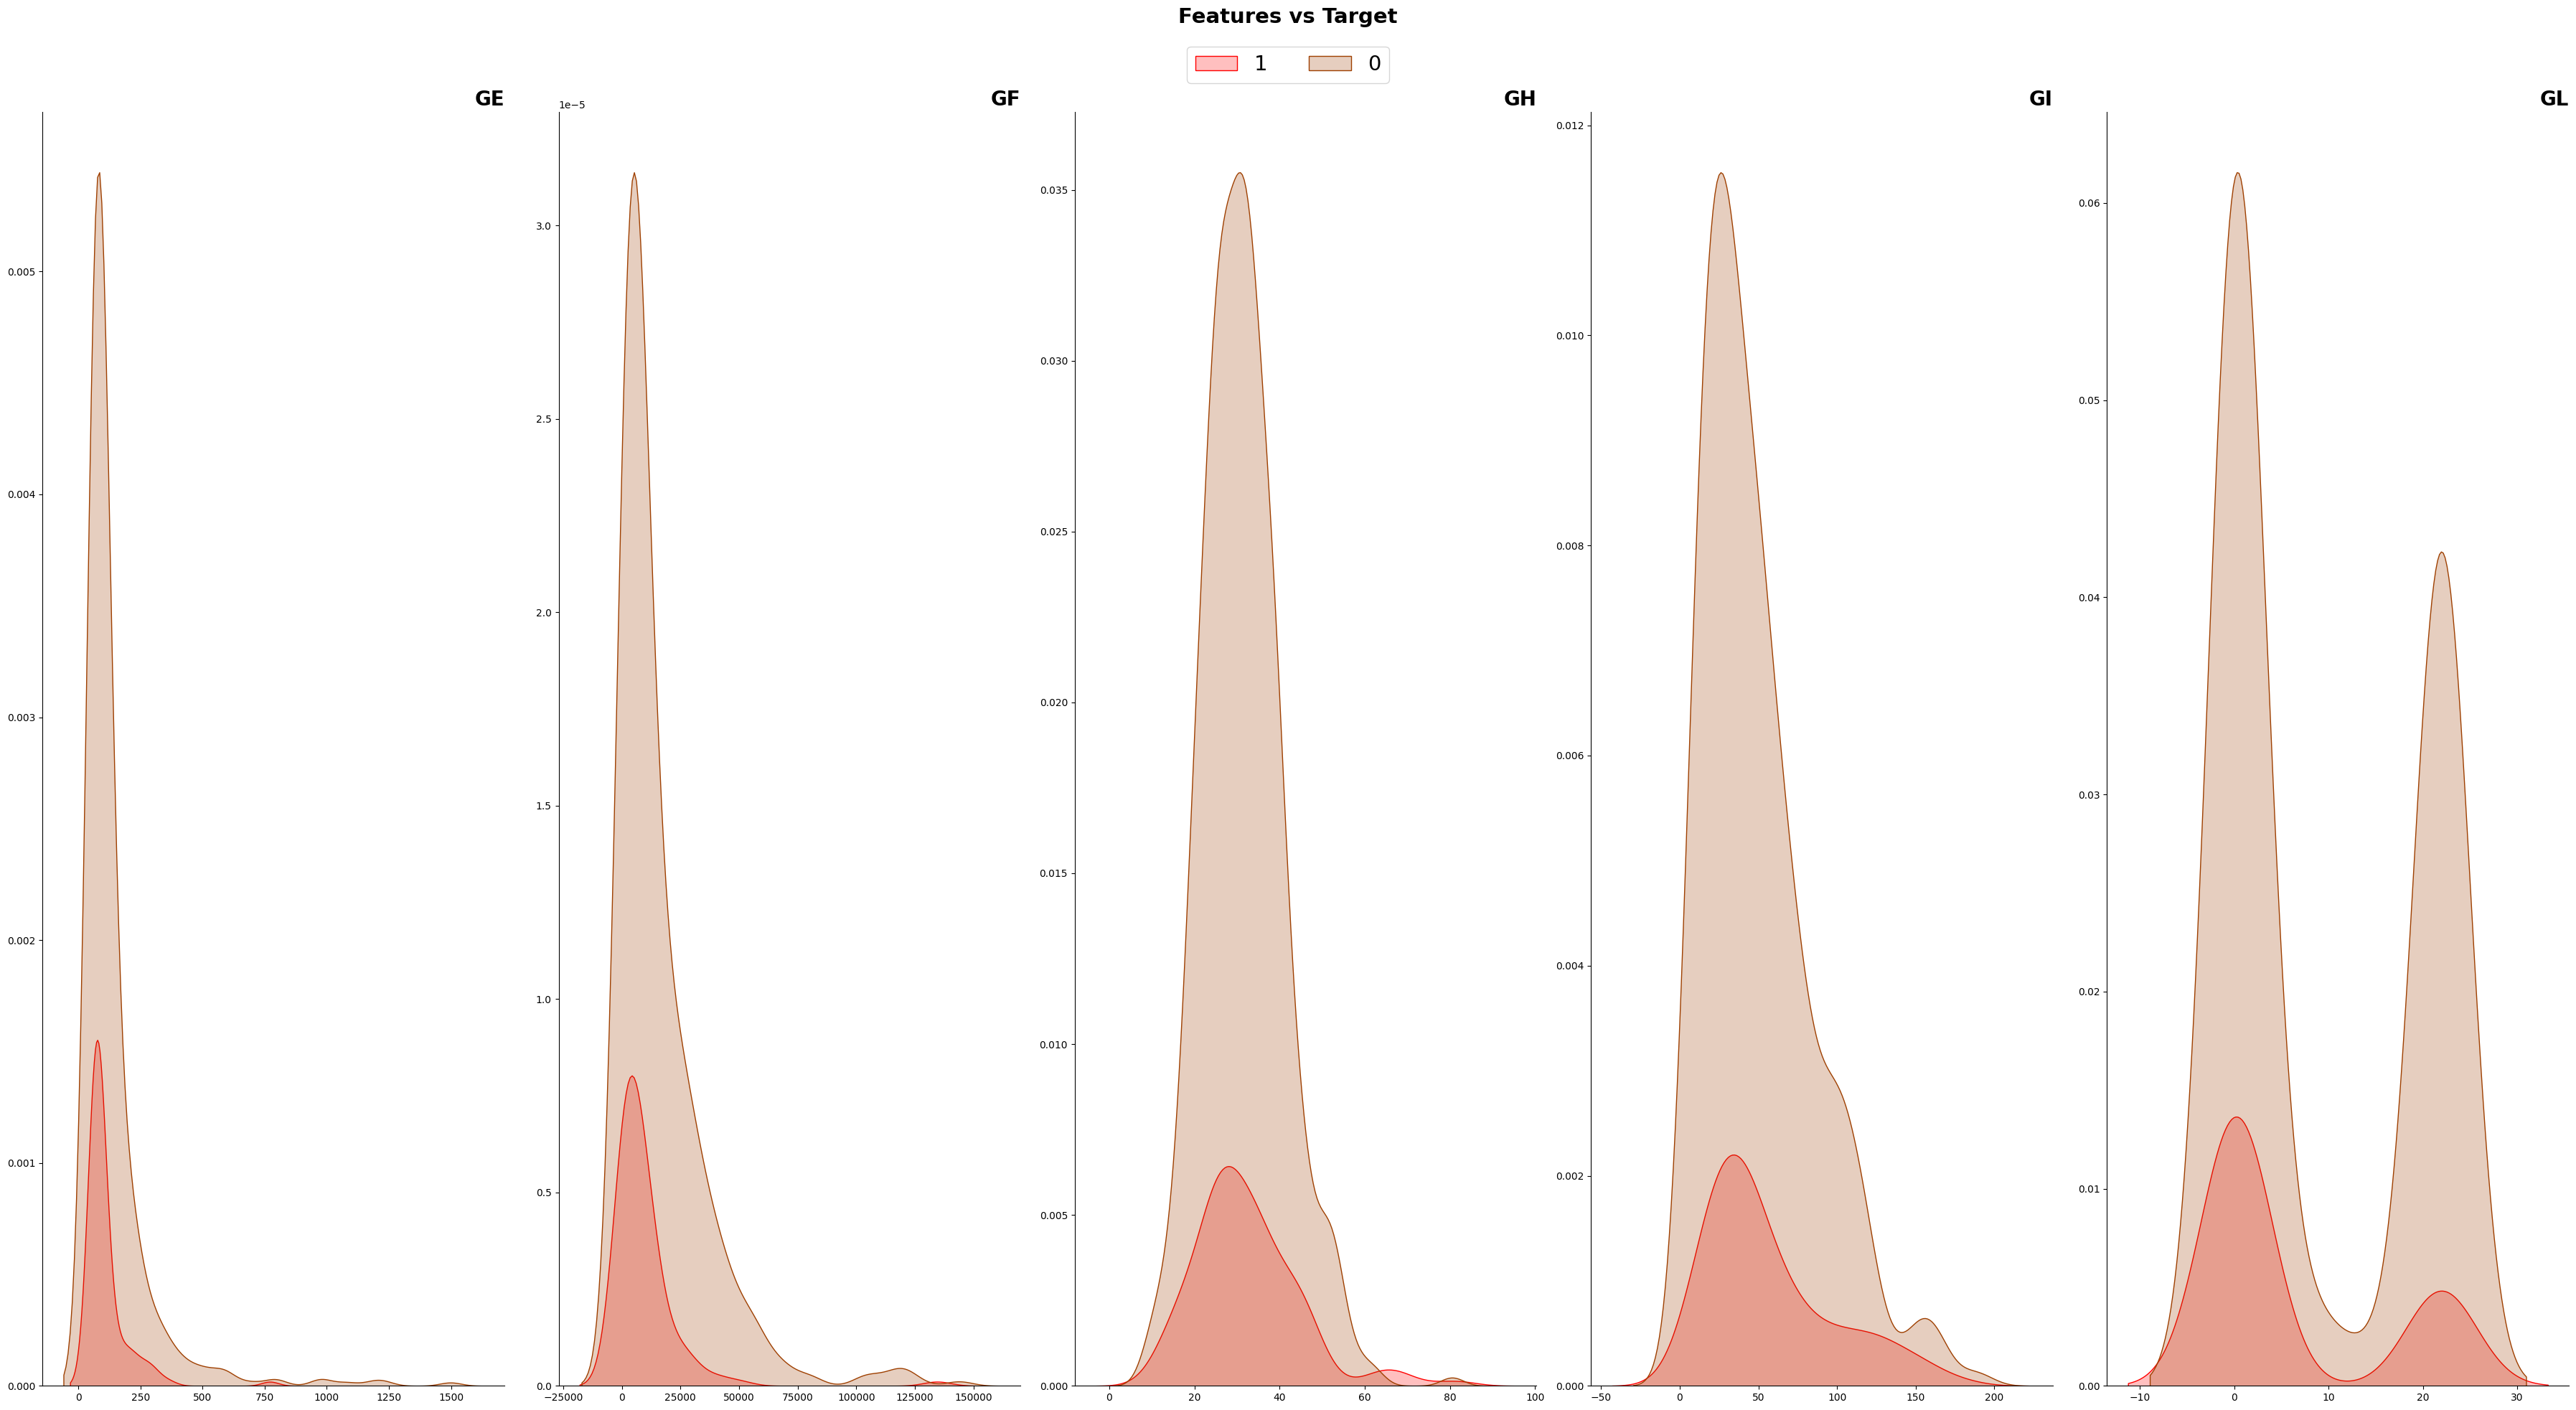

In [21]:
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(sets[5]):
    ax = plt.subplot(1,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
plt.tight_layout()
plt.show()

The distribution is different obviously, which means these variables have predictive power in some sense.

However, some variables need to be scaled.

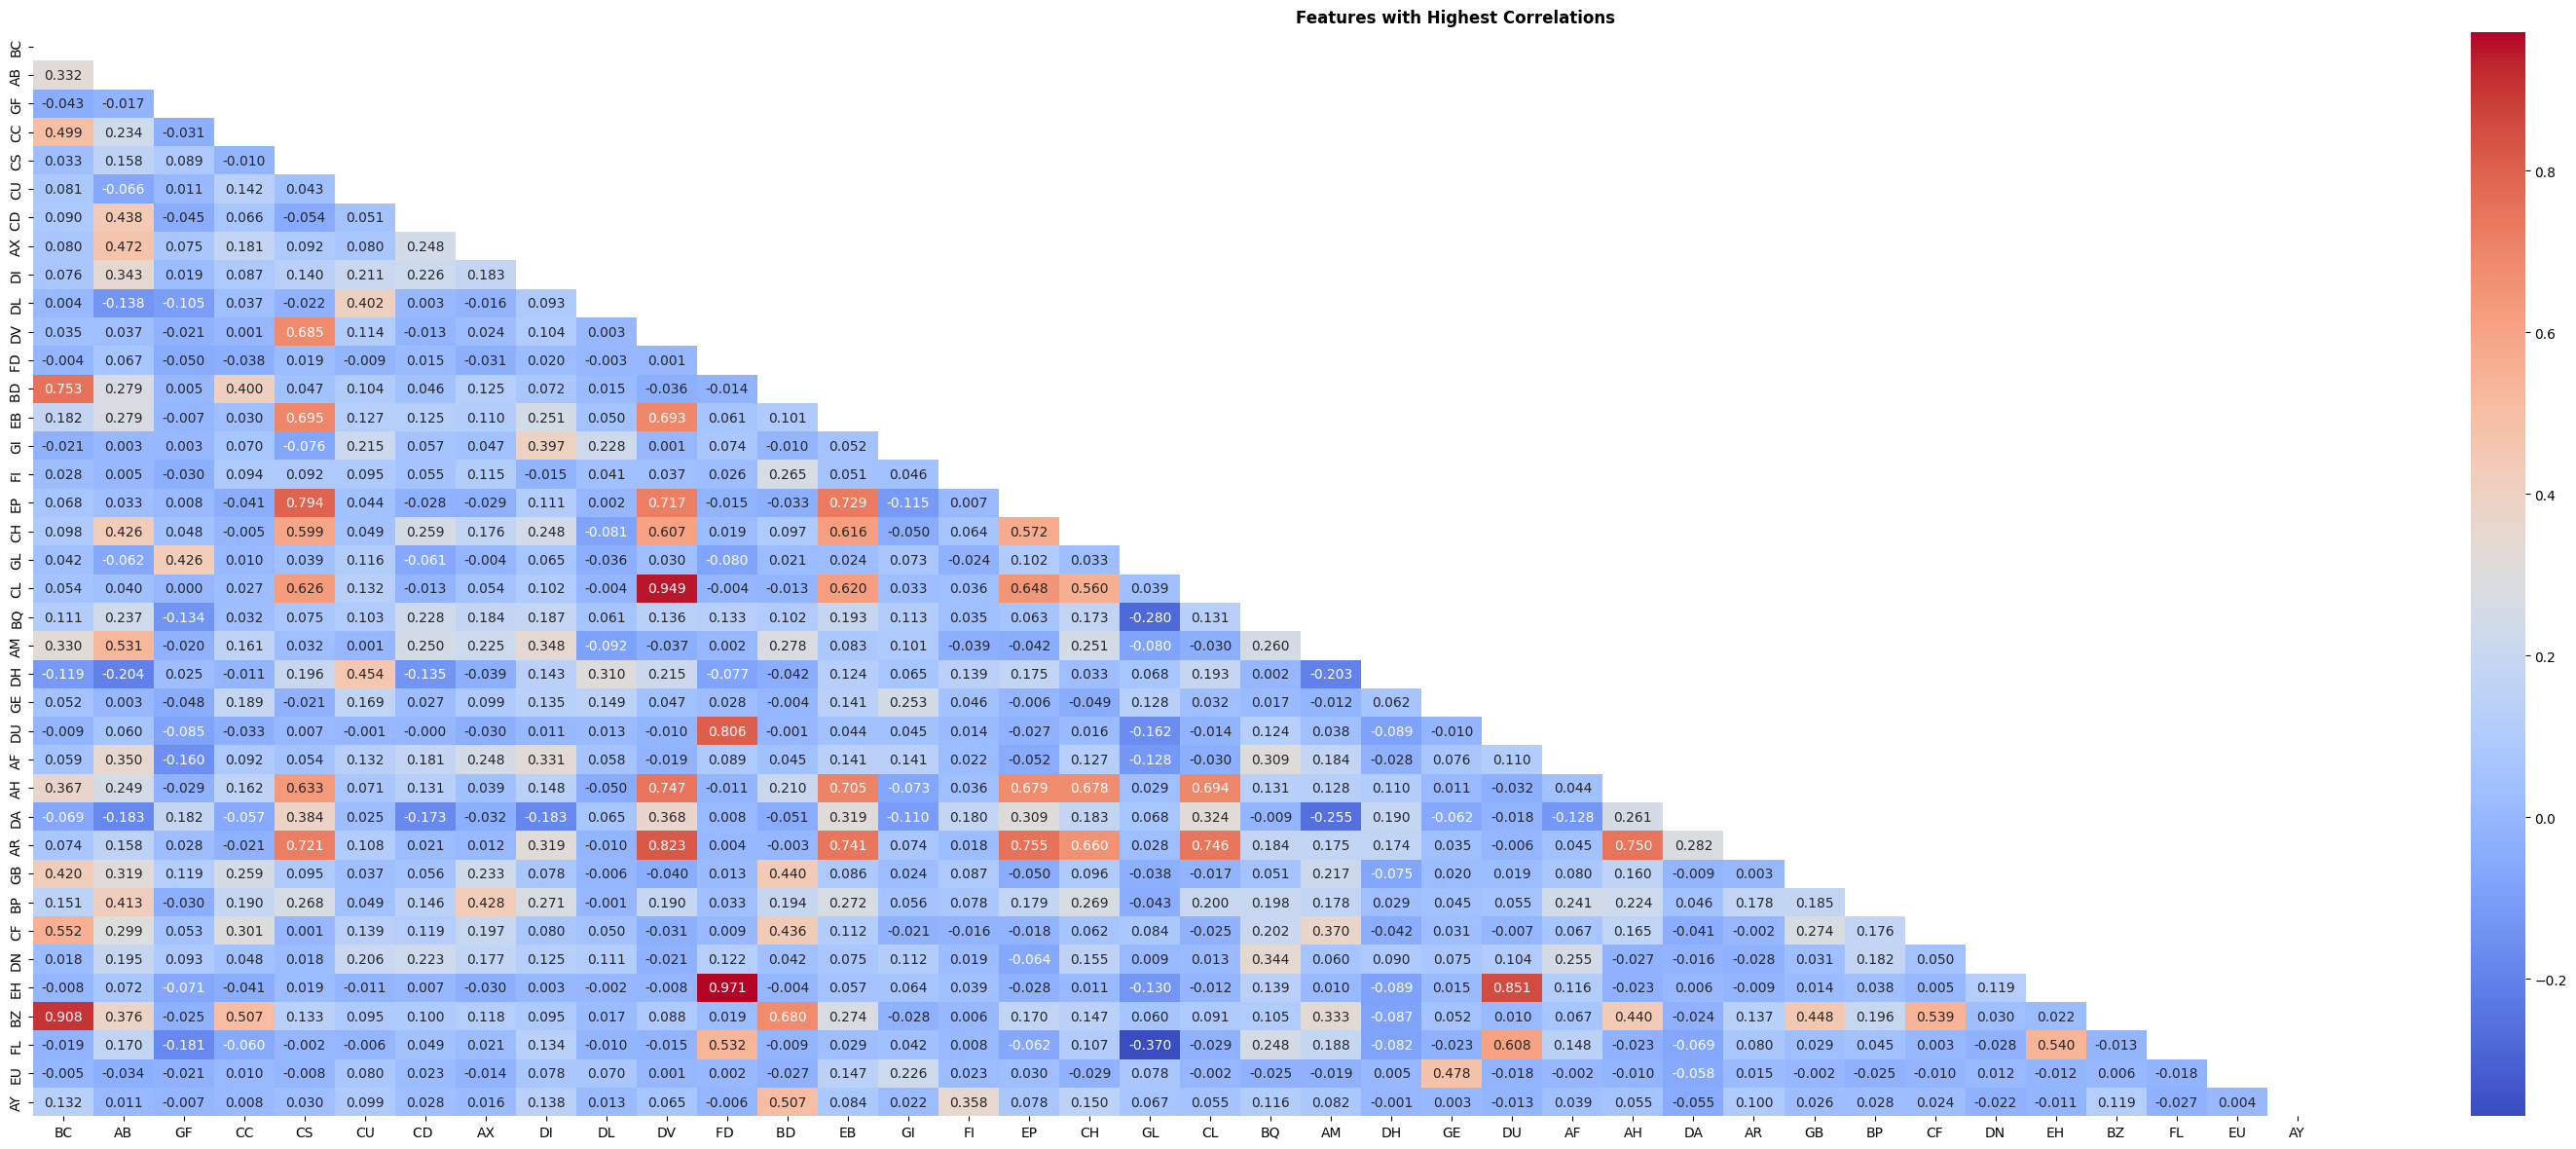

In [22]:
#Check Correlation between features
correlations = train.loc[:,num_cols].corr().abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(34).tolist()
corr_min=list(set(corr_min)) #removing duplicates


correlation_train = train.loc[:,corr_max].corr()
mask = np.triu(correlation_train.corr())

plt.figure(figsize=(30, 12))
sns.heatmap(correlation_train,
            mask=mask,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            linewidths=0.00,
            cbar=True)


plt.suptitle('Features with Highest Correlations',  weight='bold')
plt.tight_layout()

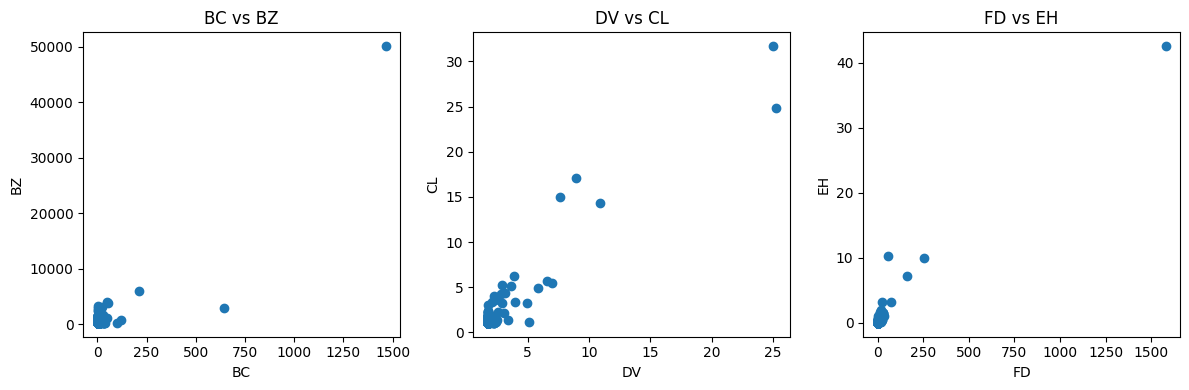

In [23]:
plt.figure(figsize=(12, 4))

# Scatter plot for BC and BZ
plt.subplot(131)
plt.scatter(train['BC'], train['BZ'])
plt.xlabel('BC')
plt.ylabel('BZ')
plt.title('BC vs BZ')

# Scatter plot for DU and CL
plt.subplot(132)
plt.scatter(train['DV'], train['CL'])
plt.xlabel('DV')
plt.ylabel('CL')
plt.title('DV vs CL')

# Scatter plot for FG and EG
plt.subplot(133)
plt.scatter(train['FD '], train['EH'])
plt.xlabel('FD')
plt.ylabel('EH')
plt.title('FD vs EH')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

There are strong relationship between BC and BZ, DV and CL, FD and EH. Therefore, I will drop BC, DV and FD.

In [24]:
remove_cols = ['BC', 'DV', 'FD ']
for col in remove_cols:
    num_cols.remove(col)
    
len(num_cols)

52

In [25]:
features=num_cols+cat_cols

In [26]:
#Data Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Fill missing values with mean for numeric variables
imputer = SimpleImputer(strategy='mean')
train_numeric_df = pd.DataFrame(imputer.fit_transform(train[num_cols]), columns=num_cols)
test_numeric_df = pd.DataFrame(imputer.fit_transform(test[num_cols]), columns=num_cols)
# Scale numeric variables using min-max scaling
scaler = MinMaxScaler()
train_scaled_numeric_df = pd.DataFrame(scaler.fit_transform(train_numeric_df), columns=num_cols)
test_scaled_numeric_df = pd.DataFrame(scaler.fit_transform(test_numeric_df), columns=num_cols)
# Encode categorical variables 
#encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
#encoded_cat_df = pd.DataFrame(encoder.fit_transform(train[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
train['EJ']= np.where(train['EJ']=='A',0,1)
train_encoded_cat_df=train['EJ']
test['EJ']= np.where(test['EJ']=='A',0,1)
test_encoded_cat_df=test['EJ']
# Concatenate the scaled numeric and encoded categorical variables
train_processed_df = pd.concat([train_scaled_numeric_df, train_encoded_cat_df],axis=1)
test_processed_df = pd.concat([test_scaled_numeric_df, test_encoded_cat_df], axis=1)

train_df=pd.concat([train_processed_df, train['Class']],axis=1)

In [27]:
train_df.head(5)

,AB,AF,AH,AM,AR,AX,AY,AZ,BD,BN,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ,Class
0,0.021082,0.102347,0.00000,0.030632,0.0,0.000000,0.000000,0.180337,0.047364,0.654545,...,0.000998,0.000866,0.054959,0.000000,0.013846,0.176983,0.362261,0.005425,1,1
1,0.010541,0.027589,0.00000,0.053864,0.0,0.078048,0.000000,0.284500,0.074042,0.490909,...,0.000000,0.016014,0.039418,0.000000,0.194527,0.274495,0.164135,1.000000,0,0
2,0.063949,0.085715,0.00000,0.046519,0.0,0.160575,0.000000,0.265013,0.067011,0.854545,...,0.000385,0.036139,0.250424,0.011229,0.095035,0.258994,0.180218,0.008910,1,0
3,0.028110,0.127285,0.01918,0.117854,0.0,0.079462,0.000000,0.215235,0.048203,0.709091,...,0.000000,0.006925,0.109565,0.006882,0.014475,0.425143,0.470820,0.007039,1,0
4,0.049192,0.124246,0.00000,0.017417,0.0,0.086300,0.002841,0.000000,0.078555,0.727273,...,0.038597,0.001731,0.093459,0.051588,0.059198,0.500829,0.185841,0.004345,1,1


In [28]:
class CFG:
    VER = 2
    AUTHOR = 'dzisandy'
    COMPETITION = 'icr-identify-age-related-conditions'
    DATA_PATH = Path('/kaggle/input/icr-identify-age-related-conditions')
    OOF_DATA_PATH = Path('./oof')
    MODEL_DATA_PATH = Path('./models')
    METHOD_LIST = ['lightgbm', 'xgboost', 'catboost']
    seed = 3407 #52
    n_folds = 10 #replaced 20
    target_col = 'Class'
    metric = 'balanced_log_loss'
    metric_maximize_flag = False
    num_boost_round = 50500
    early_stopping_round = 500
    verbose = 2000
    boosting_type = 'dart'
    lgb_params = {
        'objective': 'binary',
        'metric': None,
        'boosting': 'dart',
        'learning_rate': 0.013618223894501217,
        'num_leaves': 49,
        'feature_fraction': 0.6754914576101523,
        'bagging_fraction': 0.9823411502309465,
        'lambda_l1': 2,
        'lambda_l2': 0.49647557228577577,
        'n_jobs': -1,
        'is_unbalance': True,
        'verbose': -1,
        'seed': seed,
        'force_col_wise': True
    }
    
    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.010087562930711648,
        'max_depth': 9,
        'colsample_bytree': 0.9465681778898052,
        'subsample': 0.9376518651708563,
        'gamma': 0.007054359339523555,
        'min_child_weight': 3,
        'lambda': 1.4699422219389708,
        'random_state': seed
    }
    
    cat_params = {
        'learning_rate': 0.004744875787589305,
        'iterations': 50500,
        'depth': 10,
        'colsample_bylevel': 0.24406468053997893,
        'subsample': 0.9412401179872553,
        'l2_leaf_reg': 9.948559240054259,
        'auto_class_weights': 'Balanced',
        'random_state': seed}

In [29]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [30]:
def balanced_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    balanced_log_loss_score = (-w0/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(1-y_pred))) - w1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred)))) / (w0+w1)
    return balanced_log_loss_score


# ====================================================
# LightGBM Metric
# ====================================================
def lgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), CFG.metric_maximize_flag

# ====================================================
# XGBoost Metric
# ====================================================

def xgb_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred)

# ====================================================
# Catboost Metric
# ====================================================
class CatboostMetric(object):
    def get_final_error(self, error, weight): return error
    def is_max_optimal(self): return CFG.metric_maximize_flag
    def evaluate(self, approxes, target, weight):
        error = balanced_log_loss(np.array(target), approxes)
        return error, 0

In [31]:
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1


def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    lgb_train = lgb.Dataset(x_train, y_train, weight=y_train.map({0: train_w0, 1: train_w1}), categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}), categorical_feature=categorical_features)
    model = lgb.train(
                params = CFG.lgb_params,
                train_set = lgb_train,
                num_boost_round = CFG.num_boost_round,
                valid_sets = [lgb_train, lgb_valid],
                early_stopping_rounds = CFG.early_stopping_round,
                verbose_eval = CFG.verbose,
                # feval = lgb_metric,
            )
    # Predict validation
    valid_pred = model.predict(x_valid)
    return model, valid_pred
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    xgb_train = xgb.DMatrix(data=x_train, label=y_train, weight=y_train.map({0: train_w0, 1: train_w1}))
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}))
    model = xgb.train(
                CFG.xgb_params, 
                dtrain = xgb_train, 
                num_boost_round = CFG.num_boost_round, 
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')], 
                early_stopping_rounds = CFG.early_stopping_round, 
                verbose_eval = CFG.verbose,
                # feval = xgb_metric, 
                # maximize = CFG.metric_maximize_flag, 
            )
    # Predict validation
    valid_pred = model.predict(xgb.DMatrix(x_valid), iteration_range=(0, model.best_ntree_limit))
    return model, valid_pred
    
def catboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list, categorical_features: list):
    train_w0, train_w1 = calc_log_loss_weight(y_train)
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid)
    cat_train = Pool(data=x_train, label=y_train, weight=y_train.map({0: train_w0, 1: train_w1}), cat_features=categorical_features)
    cat_valid = Pool(data=x_valid, label=y_valid, weight=y_valid.map({0: valid_w0, 1: valid_w1}), cat_features=categorical_features)
    model = CatBoostClassifier(**CFG.cat_params) # , eval_metric = CatboostMetric
    model.fit(cat_train, 
              eval_set=[cat_valid],
              early_stopping_rounds=CFG.early_stopping_round, 
              verbose=CFG.verbose, 
              use_best_model=True)
    # Predict validation
    valid_pred = model.predict_proba(x_valid)[:, 1]
    return model, valid_pred

In [32]:
#Cross Validatoin
def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list, categorical_features: list):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_df, train_df[CFG.target_col])):
        print('-'*50)
        print(f'{method} training fold {fold + 1}')
        
        x_train = train_df[features].iloc[train_index]
        y_train = train_df[CFG.target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[CFG.target_col].iloc[valid_index]
        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        if method == 'catboost':
            model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        # Save best model
        pickle.dump(model, open(CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))
        # Add to out of folds array
        oof_predictions[valid_index] = valid_pred
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()

    # Compute out of folds metric
    score = balanced_log_loss(train_df[CFG.target_col], oof_predictions)
    print(f'{method} our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
    oof_df.to_csv(CFG.MODEL_DATA_PATH / f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv', index = False)

In [33]:
for method in CFG.METHOD_LIST:
    gradient_boosting_model_cv_training(method, train_df, features, cat_cols)

--------------------------------------------------
lightgbm training fold 1
[2000]	training's binary_logloss: 0.0312545	valid_1's binary_logloss: 0.366202
[4000]	training's binary_logloss: 0.0162023	valid_1's binary_logloss: 0.391853
[6000]	training's binary_logloss: 0.0130403	valid_1's binary_logloss: 0.383604
[8000]	training's binary_logloss: 0.0131116	valid_1's binary_logloss: 0.364379
[10000]	training's binary_logloss: 0.0133757	valid_1's binary_logloss: 0.361273
[12000]	training's binary_logloss: 0.0135206	valid_1's binary_logloss: 0.362437
[14000]	training's binary_logloss: 0.0136677	valid_1's binary_logloss: 0.366417
[16000]	training's binary_logloss: 0.0136961	valid_1's binary_logloss: 0.372884
[18000]	training's binary_logloss: 0.0137355	valid_1's binary_logloss: 0.374861
[20000]	training's binary_logloss: 0.0136552	valid_1's binary_logloss: 0.377139
[22000]	training's binary_logloss: 0.0136568	valid_1's binary_logloss: 0.379715
[24000]	training's binary_logloss: 0.0136408	val

In [34]:
def lightgbm_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds
def xgboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'xgboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict(xgb.DMatrix(x_test), iteration_range=(0, model.best_ntree_limit))
    return test_pred / CFG.n_folds
    
def catboost_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(CFG.MODEL_DATA_PATH / f'catboost_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'rb'))
        # Predict
        test_pred += model.predict_proba(x_test)[:, 1]
    return test_pred / CFG.n_folds

def gradient_boosting_model_inference(method: str, test_df: pd.DataFrame, features: list, categorical_features: list):
    x_test = test_df[features]
    if method == 'lightgbm':
        test_pred = lightgbm_inference(x_test)
    if method == 'xgboost':
        test_pred = xgboost_inference(x_test)
    if method == 'catboost':
        test_pred = catboost_inference(x_test)
    return test_pred

In [35]:
for method in CFG.METHOD_LIST:
    test_processed_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, test_processed_df , features, cat_cols)

In [36]:
test_processed_df['class_1'] = 0.8 * test_processed_df['lightgbm_pred_prob'] + 0.1 * test_processed_df['xgboost_pred_prob'] + 0.1 * test_processed_df['catboost_pred_prob']
test_processed_df['class_0'] = 1 - test_processed_df['class_1']
sample_submission['Id'] = test['Id']
sample_submission[['class_0','class_1']] = test_processed_df[['class_0','class_1']]

In [37]:
sample_submission.to_csv('submission.csv',index=False)

In [38]:
# Confusion Matrix for the last fold
#cm = confusion_matrix(y_valid, model.predict(X_valid))

# Feature Importance for the last model
#feature_imp = pd.DataFrame({'Value':xgb_models[-1].feature_importances_, 'Feature':X.columns})
#feature_imp = feature_imp.sort_values(by="Value", ascending=False)
#feature_imp_top20 = feature_imp.iloc[:20]

#fig, ax = plt.subplots(1, 2, figsize=(14, 4))

# Subplot 1: Confusion Matrix
#sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='YlOrRd')
#ax[0].set_title('Confusion Matrix')
#ax[0].set_xlabel('Predicted')
#ax[0].set_ylabel('True')

# Subplot 2: Feature Importance
#sns.barplot(x="Value", y="Feature", data=feature_imp_top20, ax=ax[1], palette='YlOrRd_r')
#ax[1].set_title('Feature Importance')

#plt.tight_layout()
#plt.show()